Propósito del Chunk: Este bloque de código calcula la duración promedio asignada a las tareas para garantizar que se ajuste a la disponibilidad horaria total de los empleados. Dado que el problema no especifica la duración exacta de cada tarea, se hace una estimación basada en los siguientes supuestos:

Tareas con competencia directa: Tienen empleados capacitados para realizarlas, por lo que se asigna una duración promedio ajustada.
Tareas sin competencia directa: Requieren el doble de tiempo, ya que ningún empleado tiene habilidades específicas para ellas, aumentando su complejidad.

In [74]:
# Diccionario que almacena la disponibilidad total en minutos de cada empleado (horas * 60).
# Esto corresponde a los horarios laborales especificados en el problema.
horarios_disponibles = {
    "E1": 10 * 60,  # 10 horas
    "E2": 8 * 60,   # 8 horas
    "E3": 6 * 60,   # 6 horas
    "E4": 5 * 60,   # 5 horas
    "E5": 8 * 60,   # 8 horas
    "E6": 8 * 60,   # 8 horas
    "E7": 8 * 60,   # 8 horas
    "E8": 8 * 60,   # 8 horas
    "E9": 6 * 60,   # 6 horas
    "E10": 8 * 60,  # 8 horas
}

# Suma la disponibilidad total de todos los empleados.
# Esto permite determinar la cantidad total de minutos disponibles en la empresa.
disponibilidad_total = sum(horarios_disponibles.values())

# Define el número de tareas con y sin competencia directa:
# - Tareas con competencia (T1 a T6): Empleados capacitados pueden realizarlas directamente.
# - Tareas sin competencia (T7 a T15): Requieren más tiempo (el doble), ya que ningún empleado tiene las habilidades exactas.
tareas_con_competencia = 6  # Número de tareas T1 a T6
tareas_sin_competencia = 9  # Número de tareas T7 a T15

# Calcula la duración promedio máxima de las tareas con competencia directa.
# Fórmula derivada de:
# disponibilidad_total = duracion_promedio * tareas_con_competencia +
#                        2 * duracion_promedio * tareas_sin_competencia.
duracion_promedio = disponibilidad_total / (tareas_con_competencia + 2 * tareas_sin_competencia)

# Calcula el tiempo total requerido para completar todas las tareas con la duración promedio.
# Este valor asegura que todas las tareas caben dentro de la disponibilidad total.
tiempo_requerido = (
    duracion_promedio * tareas_con_competencia
    + 2 * duracion_promedio * tareas_sin_competencia
)

# Tiempo restante disponible para tareas sin competencia después de asignar las tareas con competencia.
# Esto sirve como validación del modelo y balance del tiempo.
sin_competencia = disponibilidad_total - (duracion_promedio * tareas_con_competencia)

# Imprime resultados clave para la validación y simulación.
print("Disponibilidad total:")
print(disponibilidad_total)
print("Duracion promedio para tareas con competencia")
print(duracion_promedio)
print("Tiempo requerido para tareas sin competencia")
print(sin_competencia)

Disponibilidad total:
4500
Duracion promedio para tareas con competencia
187.5
Tiempo requerido para tareas sin competencia
3375.0


In [75]:
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment
from datetime import datetime

# Funciones auxiliares
def horario_a_minutos(hora_str):
    """
    Convierte un horario en formato 'HH:MM' a minutos desde medianoche.
    Este cálculo facilita la comparación y manipulación de horarios en cálculos posteriores.
    """
    return int(datetime.strptime(hora_str, '%H:%M').hour) * 60 + int(datetime.strptime(hora_str, '%H:%M').minute)

def minutos_a_horario(minutos):
    """
    Convierte una cantidad de minutos desde medianoche a formato 'HH:MM'.
    Esto permite presentar resultados en un formato más comprensible para los usuarios.
    """
    horas = minutos // 60
    mins = minutos % 60
    return f"{int(horas):02d}:{int(mins):02d}"

# Datos de empleados
empleados = {
    # Cada empleado tiene un conjunto de competencias (tareas que puede realizar)
    # y su horario de inicio y fin de jornada laboral.
    'E1': {'competencias': ['T1', 'T4', 'T5'], 'inicio': '08:00', 'fin': '18:00'},
    'E2': {'competencias': ['T1', 'T2', 'T4'], 'inicio': '09:00', 'fin': '17:00'},
    'E3': {'competencias': ['T2', 'T3', 'T5'], 'inicio': '10:00', 'fin': '16:00'},
    'E4': {'competencias': ['T1', 'T3', 'T4'], 'inicio': '12:00', 'fin': '17:00'},
    'E5': {'competencias': ['T2', 'T5', 'T6'], 'inicio': '08:00', 'fin': '16:00'},
    'E6': {'competencias': ['T3', 'T4', 'T6'], 'inicio': '10:00', 'fin': '18:00'},
    'E7': {'competencias': ['T1', 'T2', 'T5'], 'inicio': '09:00', 'fin': '17:00'},
    'E8': {'competencias': ['T3', 'T4', 'T6'], 'inicio': '10:00', 'fin': '18:00'},
    'E9': {'competencias': ['T1', 'T3', 'T5'], 'inicio': '12:00', 'fin': '18:00'},
    'E10': {'competencias': ['T2', 'T4', 'T6'], 'inicio': '11:00', 'fin': '19:00'},
}

# Datos de tareas
tareas = {
    # Cada tarea tiene un nivel de prioridad (3: Alta, 2: Media, 1: Baja).
    'T1': {'prioridad': 3}, 'T2': {'prioridad': 2}, 'T3': {'prioridad': 1},
    'T4': {'prioridad': 3}, 'T5': {'prioridad': 2}, 'T6': {'prioridad': 1},
    'T7': {'prioridad': 3}, 'T8': {'prioridad': 2}, 'T9': {'prioridad': 1},
    'T10': {'prioridad': 3}, 'T11': {'prioridad': 2}, 'T12': {'prioridad': 1},
    'T13': {'prioridad': 3}, 'T14': {'prioridad': 2}, 'T15': {'prioridad': 1},
}

# Asignar duraciones según la especificación
for tarea in tareas.keys():
    """
    Para cada tarea:
    - Si al menos un empleado puede realizarla (es decir, la tarea está en las competencias de algún empleado),
      se le asigna una duración promedio de 187.5 minutos.
    - Si no hay ningún empleado que pueda realizarla directamente,
      se considera que requiere el doble de tiempo (375 minutos).
    """
    if any(tarea in empleado['competencias'] for empleado in empleados.values()):
        tareas[tarea]['duracion'] = 187.5  # Duración promedio para tareas con competencia directa
    else:
        tareas[tarea]['duracion'] = 375  # Duración promedio para tareas sin competencia directa

# Convertir horarios de empleados a minutos desde medianoche
for e in empleados.values():
    """
    Para cada empleado:
    - Se convierten sus horarios de inicio y fin a minutos desde medianoche.
    - Se calcula la disponibilidad total como la diferencia entre el horario de fin e inicio.
    - Se inicializa la carga acumulada como 0, indicando que no se le han asignado tareas aún.
    """
    e['inicio_minutos'] = horario_a_minutos(e['inicio'])
    e['fin_minutos'] = horario_a_minutos(e['fin'])
    e['disponibilidad'] = e['fin_minutos'] - e['inicio_minutos']
    e['carga_acumulada'] = 0


In [78]:
# Crear matriz de costos
empleados_nombres = list(empleados.keys())  # Obtener los nombres de los empleados
tareas_nombres = list(tareas.keys())  # Obtener los nombres de las tareas
num_empleados = len(empleados_nombres)  # Calcular el número total de empleados
num_tareas = len(tareas_nombres)  # Calcular el número total de tareas

MAX_COST = 1e6  # Penalización alta para asignaciones no válidas (valores muy grandes)
costo_matriz = np.full((num_empleados, num_tareas), MAX_COST)  # Inicializar la matriz de costos con penalización máxima

# Iterar sobre todos los empleados y las tareas para llenar la matriz de costos
for i, e in enumerate(empleados_nombres):
    for j, t in enumerate(tareas_nombres):
        empleado = empleados[e]  # Obtener los datos del empleado
        tarea = tareas[t]  # Obtener los datos de la tarea
        if tarea['duracion'] <= empleado['disponibilidad']:  # Verificar si la tarea cabe en el tiempo disponible del empleado
            # Validar duraciones ajustadas para tareas sin competencia (si la tarea no es competencia del empleado)
            if t not in empleado['competencias'] and tarea['duracion'] > 187.5:
                continue  # Omite esta asignación, ya que no es válida

            # Mejora: Costo ajustado considerando balance de carga e inactividad
            carga_actual = empleado['carga_acumulada']  # Obtener la carga actual del empleado
            tiempo_inactivo = max(0, empleado['disponibilidad'] - tarea['duracion'])  # Calcular el tiempo inactivo (si sobra tiempo)

            if t in empleado['competencias']:  # Si el empleado tiene la competencia para la tarea
                # Ajuste del costo: Alta prioridad para tareas con competencia, penalización por inactividad y carga acumulada
                costo_matriz[i, j] = -1 * (
                    tarea['prioridad'] * 10  # Prioridad de la tarea (más peso si es de alta prioridad)
                    + empleado['disponibilidad'] / 10  # Considera la disponibilidad del empleado
                    - carga_actual  # Penaliza según la carga acumulada del empleado
                    - tiempo_inactivo / 5  # Penalización menor por tiempo inactivo
                )
            else:  # Si el empleado no tiene la competencia para la tarea
                # Ajuste del costo para tareas sin competencia (menos prioridad)
                costo_matriz[i, j] = -1 * (
                    tarea['prioridad'] * 5  # Menor prioridad para tareas sin competencia
                    - carga_actual  # Penaliza según la carga acumulada del empleado
                    - tiempo_inactivo / 10  # Penalización más baja para tareas sin competencia y tiempo inactivo
                )

# Mostrar la matriz de costos para verificar
print("\nMatriz de Costos Mejorada:")
print(costo_matriz)





Matriz de Costos Mejorada:
[[-7.500e+00  3.125e+01  3.625e+01 -7.500e+00  2.500e+00  3.625e+01
   1.000e+06  1.000e+06  1.000e+06  1.000e+06  1.000e+06  1.000e+06
   1.000e+06  1.000e+06  1.000e+06]
 [-1.950e+01 -9.500e+00  2.425e+01 -1.950e+01  1.925e+01  2.425e+01
   1.000e+06  1.000e+06  1.000e+06  1.000e+06  1.000e+06  1.000e+06
   1.000e+06  1.000e+06  1.000e+06]
 [ 2.250e+00 -2.150e+01 -1.150e+01  2.250e+00 -2.150e+01  1.225e+01
   1.000e+06  1.000e+06  1.000e+06  1.000e+06  1.000e+06  1.000e+06
   1.000e+06  1.000e+06  1.000e+06]
 [-3.750e+01  1.250e+00 -1.750e+01 -3.750e+01  1.250e+00  6.250e+00
   1.000e+06  1.000e+06  1.000e+06  1.000e+06  1.000e+06  1.000e+06
   1.000e+06  1.000e+06  1.000e+06]
 [ 1.425e+01 -9.500e+00  2.425e+01  1.425e+01 -9.500e+00  5.000e-01
   1.000e+06  1.000e+06  1.000e+06  1.000e+06  1.000e+06  1.000e+06
   1.000e+06  1.000e+06  1.000e+06]
 [ 1.425e+01  1.925e+01  5.000e-01 -1.950e+01  1.925e+01  5.000e-01
   1.000e+06  1.000e+06  1.000e+06  1.000e+0

In [79]:
# Resolver el problema de emparejamiento usando el algoritmo húngaro
fila_ind, col_ind = linear_sum_assignment(costo_matriz)

# Extraer resultados iniciales
asignaciones = []
for f, c in zip(fila_ind, col_ind):
    empleado = empleados_nombres[f]  # Obtener el nombre del empleado
    tarea = tareas_nombres[c]  # Obtener el nombre de la tarea
    if costo_matriz[f, c] < MAX_COST:  # Solo asignaciones válidas, aquellas con costo menor que el valor máximo
        tarea_inicio = empleados[empleado]['inicio_minutos']  # Calcular el inicio de la tarea en minutos
        tarea_fin = tarea_inicio + tareas[tarea]['duracion']  # Calcular el fin de la tarea en minutos

        # Validar que la tarea cabe dentro de la disponibilidad del empleado
        if tarea_fin <= empleados[empleado]['fin_minutos']:  # Verificar si la tarea puede terminar antes del fin del turno
            asignaciones.append({
                'Empleado': empleado,
                'Tarea': tarea,
                'Prioridad': tareas[tarea]['prioridad'],
                'Inicio': minutos_a_horario(tarea_inicio),  # Convertir minutos de inicio a formato horario (HH:MM)
                'Fin': minutos_a_horario(tarea_fin),  # Convertir minutos de fin a formato horario (HH:MM)
                'Duración': tareas[tarea]['duracion']  # Guardar la duración de la tarea
            })
            # Actualizar estado del empleado
            empleados[empleado]['inicio_minutos'] = tarea_fin  # El nuevo inicio del empleado es el fin de la tarea
            empleados[empleado]['disponibilidad'] -= tareas[tarea]['duracion']  # Reducir la disponibilidad del empleado
            empleados[empleado]['carga_acumulada'] += tareas[tarea]['duracion']  # Acumular el tiempo de carga del empleado
        else:
            print(f"⚠️ Tarea {tarea} no puede ser asignada a {empleado} por falta de disponibilidad.")  # Imprimir advertencia si no cabe en el horario

# Verificar asignaciones iniciales
print("\nAsignaciones Iniciales (Optimización con Algoritmo Húngaro):")
if asignaciones:
    for asignacion in asignaciones:
        print(asignacion)  # Imprimir las asignaciones que se han realizado
else:
    print("No se realizaron asignaciones válidas.")  # Mensaje si no hay asignaciones válidas

# Validar tareas no asignadas
tareas_asignadas = {asig['Tarea'] for asig in asignaciones}  # Obtener un conjunto de tareas asignadas
tareas_no_asignadas = set(tareas_nombres) - tareas_asignadas  # Calcular las tareas que no fueron asignadas
if tareas_no_asignadas:
    print("\n⚠️ Tareas no asignadas debido a restricciones:")
    print(tareas_no_asignadas)  # Imprimir las tareas que no pudieron ser asignadas
else:
    print("\n✅ Todas las tareas fueron asignadas correctamente.")  # Mensaje si todas las tareas fueron asignadas




Asignaciones Iniciales (Optimización con Algoritmo Húngaro):
{'Empleado': 'E2', 'Tarea': 'T4', 'Prioridad': 3, 'Inicio': '09:00', 'Fin': '12:07', 'Duración': 187.5}
{'Empleado': 'E3', 'Tarea': 'T2', 'Prioridad': 2, 'Inicio': '10:00', 'Fin': '13:07', 'Duración': 187.5}
{'Empleado': 'E4', 'Tarea': 'T3', 'Prioridad': 1, 'Inicio': '12:00', 'Fin': '15:07', 'Duración': 187.5}
{'Empleado': 'E6', 'Tarea': 'T6', 'Prioridad': 1, 'Inicio': '10:00', 'Fin': '13:07', 'Duración': 187.5}
{'Empleado': 'E7', 'Tarea': 'T1', 'Prioridad': 3, 'Inicio': '09:00', 'Fin': '12:07', 'Duración': 187.5}
{'Empleado': 'E9', 'Tarea': 'T5', 'Prioridad': 2, 'Inicio': '12:00', 'Fin': '15:07', 'Duración': 187.5}

⚠️ Tareas no asignadas debido a restricciones:
{'T12', 'T9', 'T15', 'T10', 'T11', 'T8', 'T7', 'T14', 'T13'}


In [80]:
# Verificar tareas sin asignar
tareas_asignadas = [asig['Tarea'] for asig in asignaciones]  # Obtener todas las tareas que ya han sido asignadas
tareas_sin_asignar = [t for t in tareas_nombres if t not in tareas_asignadas]  # Identificar las tareas que no fueron asignadas

# Ordenar tareas sin asignar por prioridad (alta -> media -> baja)
tareas_sin_asignar.sort(key=lambda t: -tareas[t]['prioridad'])  # Ordenar las tareas sin asignar según su prioridad, de alta a baja

# Forzar asignación de tareas restantes
for tarea in tareas_sin_asignar:
    duracion_restante = tareas[tarea]['duracion']  # Obtener la duración restante de la tarea
    while duracion_restante > 0:  # Mientras haya tiempo restante por asignar
        # Ordenar empleados por disponibilidad y menor carga acumulada
        empleados_ordenados = sorted(
            empleados_nombres, key=lambda e: (empleados[e]['disponibilidad'], -empleados[e]['carga_acumulada']), reverse=True
        )  # Ordenar los empleados primero por disponibilidad y luego por carga acumulada (de menor a mayor)

        for empleado in empleados_ordenados:  # Asignar tareas a los empleados ordenados
            if empleados[empleado]['disponibilidad'] > 0:  # Verificar que el empleado tiene tiempo disponible
                tiempo_asignado = min(duracion_restante, empleados[empleado]['disponibilidad'])  # Asignar el tiempo disponible del empleado
                tarea_inicio = empleados[empleado]['inicio_minutos']  # Calcular el inicio de la tarea
                tarea_fin = tarea_inicio + tiempo_asignado  # Calcular el fin de la tarea
                asignaciones.append({
                    'Empleado': empleado,  # Registrar el empleado asignado
                    'Tarea': tarea,  # Registrar la tarea asignada
                    'Prioridad': tareas[tarea]['prioridad'],  # Registrar la prioridad de la tarea
                    'Inicio': minutos_a_horario(tarea_inicio),  # Convertir el inicio a formato HH:MM
                    'Fin': minutos_a_horario(tarea_fin),  # Convertir el fin a formato HH:MM
                })
                empleados[empleado]['inicio_minutos'] = tarea_fin  # Actualizar el inicio del empleado
                empleados[empleado]['disponibilidad'] -= tiempo_asignado  # Reducir la disponibilidad del empleado
                empleados[empleado]['carga_acumulada'] += tiempo_asignado  # Actualizar la carga acumulada del empleado
                duracion_restante -= tiempo_asignado  # Reducir la duración restante de la tarea
                break  # Pasar al siguiente empleado si se asignó la tarea

# Verificar asignaciones adicionales
print("\nAsignaciones después de la reasignación de tareas restantes:")
for asignacion in asignaciones:
    print(asignacion)  # Imprimir las asignaciones realizadas, incluidas las reasignaciones de tareas no asignadas previamente




Asignaciones después de la reasignación de tareas restantes:
{'Empleado': 'E2', 'Tarea': 'T4', 'Prioridad': 3, 'Inicio': '09:00', 'Fin': '12:07', 'Duración': 187.5}
{'Empleado': 'E3', 'Tarea': 'T2', 'Prioridad': 2, 'Inicio': '10:00', 'Fin': '13:07', 'Duración': 187.5}
{'Empleado': 'E4', 'Tarea': 'T3', 'Prioridad': 1, 'Inicio': '12:00', 'Fin': '15:07', 'Duración': 187.5}
{'Empleado': 'E6', 'Tarea': 'T6', 'Prioridad': 1, 'Inicio': '10:00', 'Fin': '13:07', 'Duración': 187.5}
{'Empleado': 'E7', 'Tarea': 'T1', 'Prioridad': 3, 'Inicio': '09:00', 'Fin': '12:07', 'Duración': 187.5}
{'Empleado': 'E9', 'Tarea': 'T5', 'Prioridad': 2, 'Inicio': '12:00', 'Fin': '15:07', 'Duración': 187.5}
{'Empleado': 'E1', 'Tarea': 'T7', 'Prioridad': 3, 'Inicio': '08:00', 'Fin': '14:15'}
{'Empleado': 'E5', 'Tarea': 'T10', 'Prioridad': 3, 'Inicio': '08:00', 'Fin': '14:15'}
{'Empleado': 'E8', 'Tarea': 'T13', 'Prioridad': 3, 'Inicio': '10:00', 'Fin': '16:15'}
{'Empleado': 'E10', 'Tarea': 'T8', 'Prioridad': 2, 'Inici

In [81]:
# Crear un DataFrame con todas las asignaciones
asignaciones_df = pd.DataFrame(asignaciones)  # Convertir la lista de asignaciones a un DataFrame para facilitar su visualización y análisis

# Crear un resumen mostrando únicamente las horas disponibles restantes
resumen = pd.DataFrame({
    'Empleado': empleados_nombres,  # Listar todos los empleados
    'Horas_Disponibles_Restantes': [e['disponibilidad'] for e in empleados.values()],  # Mostrar las horas restantes disponibles para cada empleado
    'Carga_Acumulada': [e['carga_acumulada'] for e in empleados.values()],  # Mostrar la carga acumulada de cada empleado
})

# Métricas de balance
cargas = [e['carga_acumulada'] for e in empleados.values()]  # Extraer las cargas acumuladas de cada empleado
carga_max = max(cargas)  # Calcular la carga máxima
carga_min = min(cargas)  # Calcular la carga mínima
carga_promedio = sum(cargas) / len(cargas)  # Calcular la carga promedio

# Mostrar los resultados
print("\nAsignaciones Finales:")  # Imprimir las asignaciones finales en formato de DataFrame
print(asignaciones_df)

print("\nResumen de Horas Disponibles Restantes y Carga Acumulada:")  # Imprimir el resumen de horas restantes y carga acumulada
print(resumen)

print("\nMétricas de Balance de Trabajo:")  # Imprimir las métricas de balance de carga de trabajo
print(f"Carga máxima: {carga_max} minutos")  # Imprimir la carga máxima
print(f"Carga mínima: {carga_min} minutos")  # Imprimir la carga mínima
print(f"Carga promedio: {carga_promedio:.2f} minutos")  # Imprimir la carga promedio con dos decimales
print(f"Diferencia máxima-mínima: {carga_max - carga_min} minutos")  # Imprimir la diferencia entre la carga máxima y mínima

# Verificar si alguna tarea fue dividida
tareas_divididas = asignaciones_df.groupby('Tarea').size()  # Agrupar las asignaciones por tarea y contar cuántos empleados están asignados a cada tarea
tareas_divididas = tareas_divididas[tareas_divididas > 1]  # Filtrar las tareas que fueron asignadas a más de un empleado

if not tareas_divididas.empty:  # Verificar si hay tareas divididas
    print("\nTareas Divididas (realizadas por más de un empleado):")  # Imprimir las tareas que han sido divididas
    print(tareas_divididas)
else:
    print("\nNo hay tareas divididas.")  # Si no hay tareas divididas, mostrar mensaje indicando que no existen





Asignaciones Finales:
   Empleado Tarea  Prioridad Inicio    Fin  Duración
0        E2    T4          3  09:00  12:07     187.5
1        E3    T2          2  10:00  13:07     187.5
2        E4    T3          1  12:00  15:07     187.5
3        E6    T6          1  10:00  13:07     187.5
4        E7    T1          3  09:00  12:07     187.5
5        E9    T5          2  12:00  15:07     187.5
6        E1    T7          3  08:00  14:15       NaN
7        E5   T10          3  08:00  14:15       NaN
8        E8   T13          3  10:00  16:15       NaN
9       E10    T8          2  11:00  17:15       NaN
10       E2   T11          2  12:07  17:00       NaN
11       E6   T11          2  13:07  14:30       NaN
12       E7   T14          2  12:07  17:00       NaN
13       E1   T14          2  14:15  15:37       NaN
14       E6    T9          1  14:30  18:00       NaN
15       E3    T9          1  13:07  15:52       NaN
16       E9   T12          1  15:07  18:00       NaN
17       E1   T12      

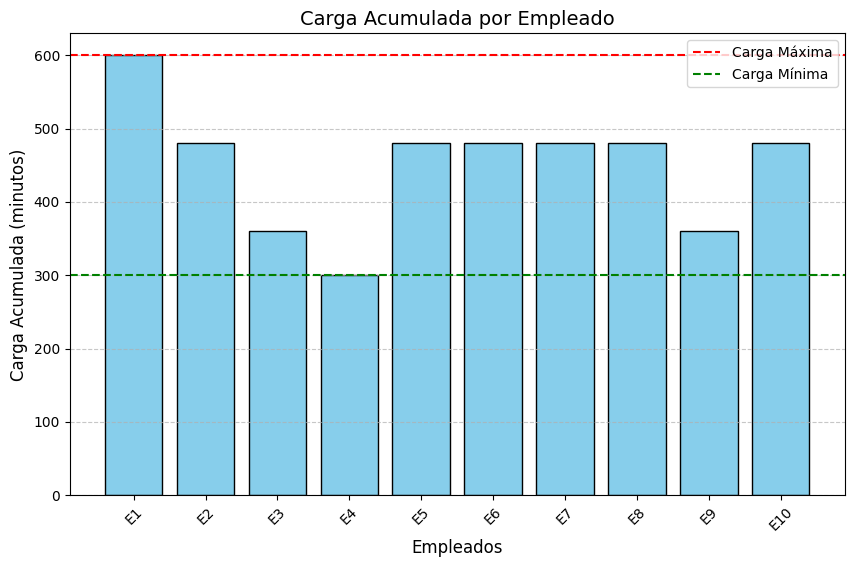

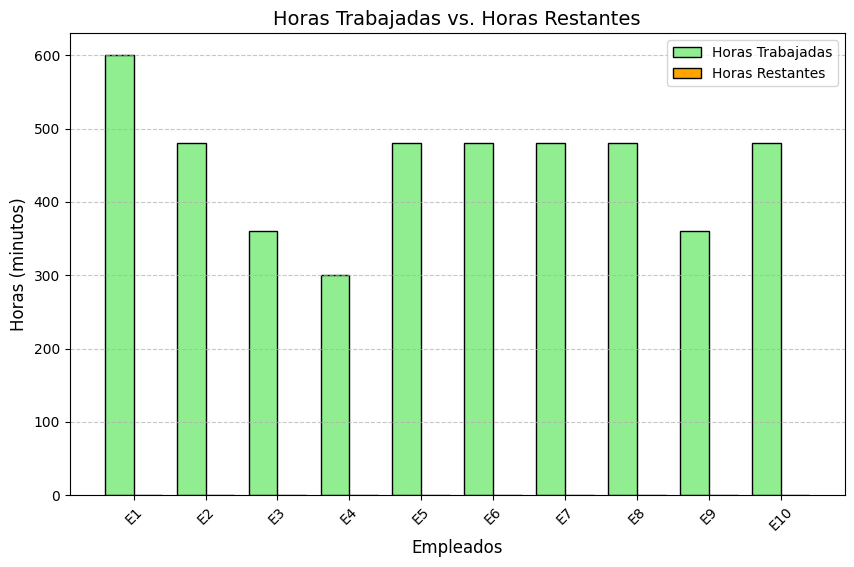

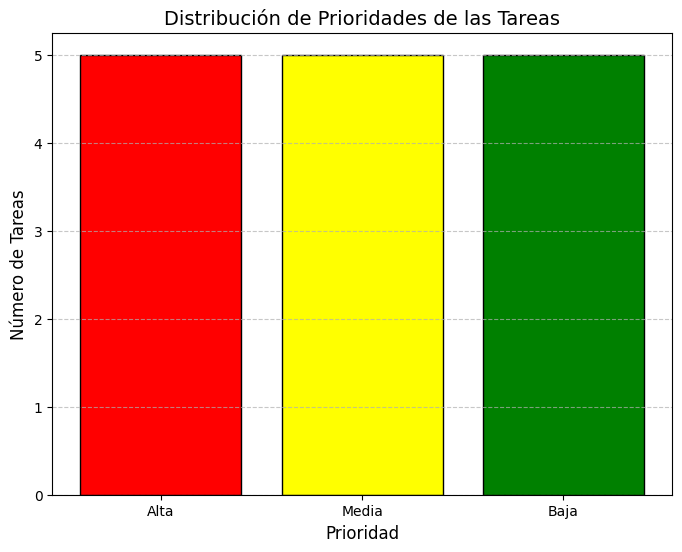

El grafo es bipartito: cumple con el modelo de grafos.

--- Resumen del Grafo ---
Número de nodos: 25
Número de aristas: 24
Aristas (empleado -> tarea con prioridad):
('E_E1', 'T_T7', {'weight': 3})
('E_E1', 'T_T14', {'weight': 2})
('E_E1', 'T_T12', {'weight': 1})
('E_E2', 'T_T4', {'weight': 3})
('E_E2', 'T_T11', {'weight': 2})
('E_E3', 'T_T2', {'weight': 2})
('E_E3', 'T_T9', {'weight': 1})
('E_E3', 'T_T15', {'weight': 1})
('E_E4', 'T_T3', {'weight': 1})
('E_E4', 'T_T12', {'weight': 1})
('E_E4', 'T_T15', {'weight': 1})
('E_E5', 'T_T10', {'weight': 3})
('E_E5', 'T_T15', {'weight': 1})
('E_E6', 'T_T6', {'weight': 1})
('E_E6', 'T_T11', {'weight': 2})
('E_E6', 'T_T9', {'weight': 1})
('E_E7', 'T_T1', {'weight': 3})
('E_E7', 'T_T14', {'weight': 2})
('E_E8', 'T_T13', {'weight': 3})
('E_E8', 'T_T15', {'weight': 1})
('E_E9', 'T_T5', {'weight': 2})
('E_E9', 'T_T12', {'weight': 1})
('E_E10', 'T_T8', {'weight': 2})
('E_E10', 'T_T15', {'weight': 1})


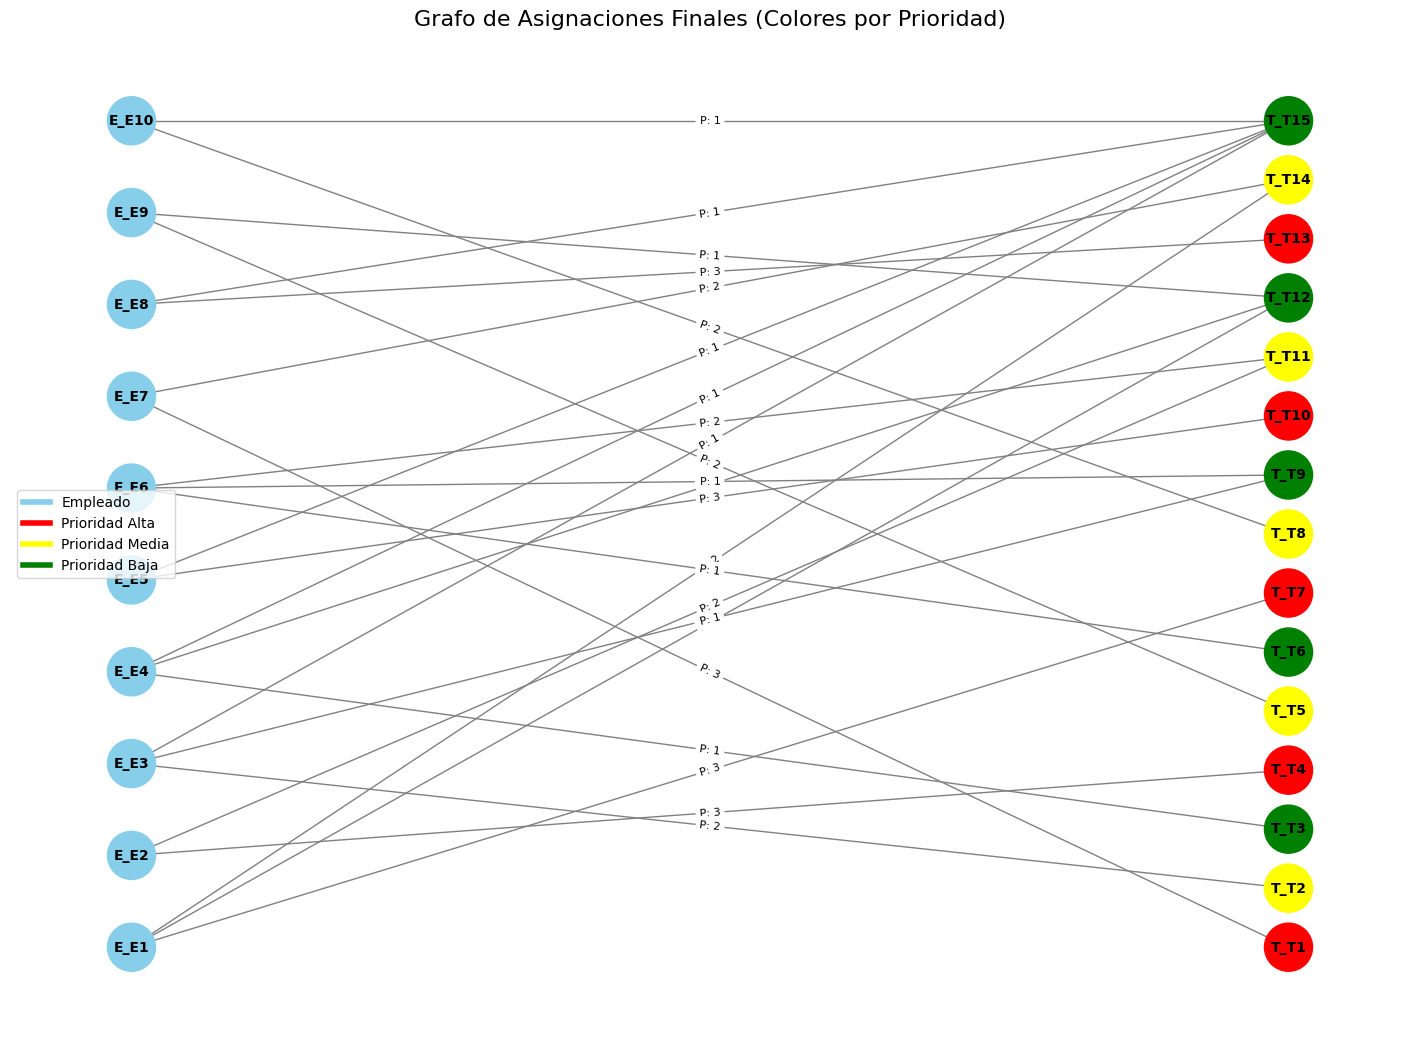

In [82]:
import matplotlib.pyplot as plt
import networkx as nx

# Gráfico de Carga Acumulada
cargas = [e['carga_acumulada'] for e in empleados.values()]  # Extraer las cargas acumuladas de cada empleado
empleados_labels = empleados_nombres  # Etiquetas de los empleados

plt.figure(figsize=(10, 6))  # Crear la figura del gráfico
plt.bar(empleados_labels, cargas, color='skyblue', edgecolor='black')  # Crear el gráfico de barras para carga acumulada
plt.axhline(y=max(cargas), color='red', linestyle='--', label='Carga Máxima')  # Línea horizontal para la carga máxima
plt.axhline(y=min(cargas), color='green', linestyle='--', label='Carga Mínima')  # Línea horizontal para la carga mínima
plt.title("Carga Acumulada por Empleado", fontsize=14)  # Título del gráfico
plt.xlabel("Empleados", fontsize=12)  # Etiqueta del eje X
plt.ylabel("Carga Acumulada (minutos)", fontsize=12)  # Etiqueta del eje Y
plt.xticks(rotation=45)  # Rotar las etiquetas de los empleados en el eje X
plt.legend()  # Mostrar la leyenda
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Añadir una cuadrícula en el eje Y
plt.show()  # Mostrar el gráfico

# Gráfico de Horas Disponibles Restantes vs. Horas Trabajadas
horas_trabajadas = [e['carga_acumulada'] for e in empleados.values()]  # Extraer las horas trabajadas por cada empleado
horas_restantes = [max(0, e['disponibilidad']) for e in empleados.values()]  # Calcular las horas restantes para cada empleado, evitando valores negativos

x = np.arange(len(empleados_labels))  # Crear posiciones para las barras

plt.figure(figsize=(10, 6))  # Crear la figura del gráfico
plt.bar(x - 0.2, horas_trabajadas, width=0.4, label='Horas Trabajadas', color='lightgreen', edgecolor='black')  # Crear las barras para las horas trabajadas
plt.bar(x + 0.2, horas_restantes, width=0.4, label='Horas Restantes', color='orange', edgecolor='black')  # Crear las barras para las horas restantes
plt.xticks(x, empleados_labels, rotation=45)  # Establecer las etiquetas de los empleados en el eje X
plt.title("Horas Trabajadas vs. Horas Restantes", fontsize=14)  # Título del gráfico
plt.xlabel("Empleados", fontsize=12)  # Etiqueta del eje X
plt.ylabel("Horas (minutos)", fontsize=12)  # Etiqueta del eje Y
plt.legend()  # Mostrar la leyenda
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Añadir una cuadrícula en el eje Y
plt.show()  # Mostrar el gráfico

# Gráfico de Distribución de Prioridades de las Tareas
prioridades = [tareas[t]['prioridad'] for t in tareas.keys()]  # Extraer las prioridades de las tareas
labels_prioridad = ['Alta', 'Media', 'Baja']  # Etiquetas para las prioridades
conteo_prioridades = [prioridades.count(3), prioridades.count(2), prioridades.count(1)]  # Contar cuántas tareas hay de cada prioridad

plt.figure(figsize=(8, 6))  # Crear la figura del gráfico
plt.bar(labels_prioridad, conteo_prioridades, color=['red', 'yellow', 'green'], edgecolor='black')  # Crear el gráfico de barras para la distribución de prioridades
plt.title("Distribución de Prioridades de las Tareas", fontsize=14)  # Título del gráfico
plt.xlabel("Prioridad", fontsize=12)  # Etiqueta del eje X
plt.ylabel("Número de Tareas", fontsize=12)  # Etiqueta del eje Y
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Añadir una cuadrícula en el eje Y
plt.show()  # Mostrar el gráfico

# Visualización del Grafo de Asignaciones Finales con Mejoras
G = nx.Graph()  # Crear un grafo vacío

# Añadir nodos para empleados y tareas
empleados_nodos = [f"E_{e}" for e in empleados.keys()]  # Crear los nodos para los empleados
tareas_nodos = [f"T_{t}" for t in tareas.keys()]  # Crear los nodos para las tareas
G.add_nodes_from(empleados_nodos, bipartite=0)  # Añadir los nodos de empleados al grafo
G.add_nodes_from(tareas_nodos, bipartite=1)  # Añadir los nodos de tareas al grafo

# Añadir aristas según las asignaciones finales
for asig in asignaciones:  # Recorrer las asignaciones realizadas
    empleado_nodo = f"E_{asig['Empleado']}"  # Crear el nodo para el empleado
    tarea_nodo = f"T_{asig['Tarea']}"  # Crear el nodo para la tarea
    peso = asig['Prioridad']  # Asignar el peso de la arista según la prioridad
    G.add_edge(empleado_nodo, tarea_nodo, weight=peso)  # Añadir la arista entre el empleado y la tarea

# Validar si el grafo es bipartito
if nx.is_bipartite(G):  # Verificar si el grafo es bipartito
    print("El grafo es bipartito: cumple con el modelo de grafos.")  # Si es bipartito, mostrar mensaje
else:
    print("Advertencia: El grafo no es bipartito.")  # Si no es bipartito, mostrar mensaje

# Resumen del grafo
print("\n--- Resumen del Grafo ---")  # Mostrar un resumen del grafo
print(f"Número de nodos: {G.number_of_nodes()}")  # Imprimir el número de nodos
print(f"Número de aristas: {G.number_of_edges()}")  # Imprimir el número de aristas
print("Aristas (empleado -> tarea con prioridad):")  # Imprimir las aristas del grafo
for edge in G.edges(data=True):  # Recorrer las aristas del grafo
    print(edge)  # Imprimir cada arista

# Asignar colores según las prioridades
color_map = []  # Crear una lista para almacenar los colores de los nodos
for node in G.nodes():  # Recorrer todos los nodos del grafo
    if node.startswith("E_"):  # Si el nodo es un empleado
        color_map.append("skyblue")  # Asignar color azul claro a los empleados
    elif node.startswith("T_"):  # Si el nodo es una tarea
        tarea = node[2:]  # Extraer el nombre de la tarea
        prioridad = tareas[tarea]['prioridad']  # Obtener la prioridad de la tarea
        if prioridad == 3:  # Si la prioridad es alta
            color_map.append("red")  # Asignar color rojo
        elif prioridad == 2:  # Si la prioridad es media
            color_map.append("yellow")  # Asignar color amarillo
        else:  # Si la prioridad es baja
            color_map.append("green")  # Asignar color verde

# Dibujar el grafo
pos = nx.drawing.layout.bipartite_layout(G, nodes=empleados_nodos)  # Agrupar los nodos de acuerdo al layout bipartito
plt.figure(figsize=(14, 10))  # Crear la figura del gráfico
nx.draw(
    G, pos, with_labels=True, node_color=color_map, edge_color="gray", font_weight="bold",  # Dibujar los nodos y aristas del grafo
    node_size=1200, font_size=10  # Establecer el tamaño de los nodos y la fuente
)
edge_labels = nx.get_edge_attributes(G, 'weight')  # Obtener los atributos de peso de las aristas
nx.draw_networkx_edge_labels(
    G, pos, edge_labels={k: f"P: {v}" for k, v in edge_labels.items()}, font_size=8  # Dibujar las etiquetas de las aristas
)
plt.title("Grafo de Asignaciones Finales (Colores por Prioridad)", fontsize=16)  # Título del gráfico
plt.legend(handles=[
    plt.Line2D([0], [0], color='skyblue', lw=4, label='Empleado'),  # Leyenda para los empleados
    plt.Line2D([0], [0], color='red', lw=4, label='Prioridad Alta'),  # Leyenda para la prioridad alta
    plt.Line2D([0], [0], color='yellow', lw=4, label='Prioridad Media'),  # Leyenda para la prioridad media
    plt.Line2D([0], [0], color='green', lw=4, label='Prioridad Baja')  # Leyenda para la prioridad baja
])
plt.show()  # Mostrar el gráfico





--- Análisis Adicional de Resultados ---
Tiempo total disponible (minutos): 4500
Tiempo total asignado (minutos): 4500
Tiempo inactivo total (minutos): 0

Distribución de Tareas por Empleado:
Empleado
E1     3
E10    2
E2     2
E3     3
E4     3
E5     2
E6     3
E7     2
E8     2
E9     2
Name: Tarea, dtype: int64


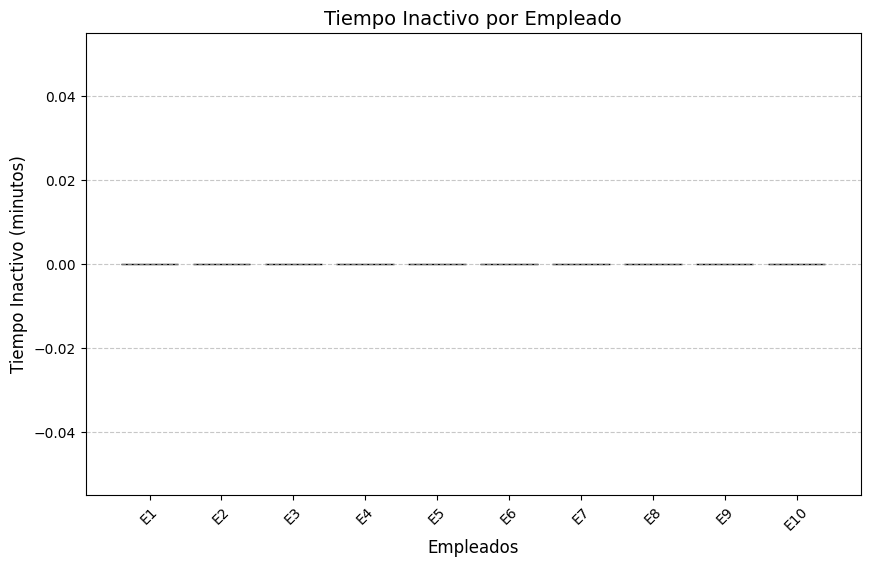

In [83]:
# Chunk: Análisis de Resultados

# Calcular métricas adicionales para evaluar asignaciones
tiempo_total_asignado = sum(
    horario_a_minutos(asig['Fin']) - horario_a_minutos(asig['Inicio'])  # Calcular el tiempo total asignado sumando la duración de cada tarea
    for asig in asignaciones_df.to_dict('records')  # Convertir las asignaciones a un diccionario y calcular la duración
)

# Calcular métricas adicionales para evaluar asignaciones
tiempo_total_disponible = sum(
    horario_a_minutos(e['fin']) - horario_a_minutos(e['inicio'])  # Calcular el tiempo total disponible sumando la duración del horario de cada empleado
    for e in empleados.values()  # Iterar sobre los datos de los empleados para calcular su disponibilidad total
)

tiempo_inactivo_total = tiempo_total_disponible - tiempo_total_asignado  # Calcular el tiempo total inactivo restando el tiempo asignado al tiempo disponible

# Distribución de tareas por empleado
tareas_por_empleado = asignaciones_df.groupby('Empleado')['Tarea'].count()  # Contar el número de tareas asignadas a cada empleado

# Mostrar métricas
print("\n--- Análisis Adicional de Resultados ---")
print(f"Tiempo total disponible (minutos): {tiempo_total_disponible}")  # Mostrar el tiempo total disponible para todos los empleados
print(f"Tiempo total asignado (minutos): {tiempo_total_asignado}")  # Mostrar el tiempo total de trabajo asignado a los empleados
print(f"Tiempo inactivo total (minutos): {tiempo_inactivo_total}")  # Mostrar el tiempo total inactivo (sin tareas asignadas)
print("\nDistribución de Tareas por Empleado:")
print(tareas_por_empleado)  # Mostrar la cantidad de tareas asignadas a cada empleado

# Graficar tiempo inactivo por empleado
tiempos_inactivos = [
    horario_a_minutos(e['fin']) - horario_a_minutos(e['inicio']) - sum(  # Calcular el tiempo inactivo para cada empleado restando el tiempo trabajado
        horario_a_minutos(asig['Fin']) - horario_a_minutos(asig['Inicio'])  # Sumar el tiempo de trabajo de cada tarea asignada al empleado
        for asig in asignaciones if asig['Empleado'] == empleado  # Filtrar las asignaciones correspondientes a cada empleado
    )
    for empleado, e in empleados.items()  # Iterar sobre los empleados para calcular su tiempo inactivo
]

# Crear gráfico de barras para mostrar el tiempo inactivo de cada empleado
plt.figure(figsize=(10, 6))  # Establecer el tamaño de la figura del gráfico
plt.bar(empleados_nombres, tiempos_inactivos, color='lightblue', edgecolor='black')  # Crear el gráfico de barras para el tiempo inactivo de los empleados
plt.title("Tiempo Inactivo por Empleado", fontsize=14)  # Título del gráfico
plt.xlabel("Empleados", fontsize=12)  # Etiqueta del eje X
plt.ylabel("Tiempo Inactivo (minutos)", fontsize=12)  # Etiqueta del eje Y
plt.xticks(rotation=45)  # Rotar las etiquetas del eje X (empleados)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Añadir una cuadrícula en el eje Y
plt.show()  # Mostrar el gráfico



Escenarios

In [84]:
def generar_escenarios():
    def procesar_empleados(empleados):
        """Agrega campos calculados (inicio_minutos, fin_minutos, disponibilidad, carga_acumulada)."""
        # Este bloque procesa los datos de los empleados, convirtiendo los horarios en minutos desde medianoche
        # y calculando la disponibilidad (tiempo que pueden trabajar) y la carga acumulada (trabajo realizado previamente).
        for nombre, datos in empleados.items():
            datos['inicio_minutos'] = horario_a_minutos(datos['inicio'])  # Hora de inicio convertida a minutos.
            datos['fin_minutos'] = horario_a_minutos(datos['fin'])  # Hora de fin convertida a minutos.
            datos['disponibilidad'] = max(0, datos['fin_minutos'] - datos['inicio_minutos'])  # Cálculo de horas disponibles.
            datos['carga_acumulada'] = 0  # Inicializamos la carga acumulada en 0.
        return empleados

    escenarios = {}

    # Escenario 1: Alta carga de trabajo con pocos empleados
    empleados_esc1 = {
        'E1': {'competencias': ['T1', 'T4'], 'inicio': '08:00', 'fin': '16:00'},
        'E2': {'competencias': ['T2', 'T5'], 'inicio': '09:00', 'fin': '17:00'},
        'E3': {'competencias': ['T1', 'T3'], 'inicio': '10:00', 'fin': '15:00'},
    }
    tareas_esc1 = {
        'T1': {'prioridad': 3, 'duracion': 300},
        'T2': {'prioridad': 2, 'duracion': 240},
        'T3': {'prioridad': 1, 'duracion': 120},
        'T4': {'prioridad': 3, 'duracion': 180},
        'T5': {'prioridad': 2, 'duracion': 200},
    }
    descripcion_esc1 = "Escenario con alta carga de trabajo y pocos empleados."

    # Escenario 2: Distribución desigual de competencias
    empleados_esc2 = {
        'E1': {'competencias': ['T1'], 'inicio': '08:00', 'fin': '18:00'},
        'E2': {'competencias': ['T2'], 'inicio': '09:00', 'fin': '17:00'},
        'E3': {'competencias': ['T3', 'T4'], 'inicio': '10:00', 'fin': '16:00'},
        'E4': {'competencias': ['T5'], 'inicio': '12:00', 'fin': '17:00'},
    }
    tareas_esc2 = {
        'T1': {'prioridad': 3, 'duracion': 150},
        'T2': {'prioridad': 3, 'duracion': 200},
        'T3': {'prioridad': 2, 'duracion': 240},
        'T4': {'prioridad': 2, 'duracion': 180},
        'T5': {'prioridad': 1, 'duracion': 120},
        'T6': {'prioridad': 1, 'duracion': 300},
    }
    descripcion_esc2 = "Escenario con distribución desigual de competencias entre empleados."

    # Escenario 3: Alta prioridad en la mayoría de las tareas
    empleados_esc3 = {
        'E1': {'competencias': ['T1', 'T2'], 'inicio': '08:00', 'fin': '16:00'},
        'E2': {'competencias': ['T3', 'T4'], 'inicio': '09:00', 'fin': '17:00'},
        'E3': {'competencias': ['T5', 'T6'], 'inicio': '10:00', 'fin': '16:00'},
        'E4': {'competencias': ['T7', 'T8'], 'inicio': '12:00', 'fin': '17:00'},
    }
    tareas_esc3 = {
        'T1': {'prioridad': 3, 'duracion': 120},
        'T2': {'prioridad': 3, 'duracion': 150},
        'T3': {'prioridad': 3, 'duracion': 200},
        'T4': {'prioridad': 3, 'duracion': 180},
        'T5': {'prioridad': 3, 'duracion': 240},
        'T6': {'prioridad': 3, 'duracion': 300},
        'T7': {'prioridad': 2, 'duracion': 120},
        'T8': {'prioridad': 1, 'duracion': 180},
    }
    descripcion_esc3 = "Escenario con alta prioridad en la mayoría de las tareas."

    # Guardar escenarios procesados en un diccionario
    escenarios['Escenario 1'] = (descripcion_esc1, procesar_empleados(empleados_esc1), tareas_esc1)
    escenarios['Escenario 2'] = (descripcion_esc2, procesar_empleados(empleados_esc2), tareas_esc2)
    escenarios['Escenario 3'] = (descripcion_esc3, procesar_empleados(empleados_esc3), tareas_esc3)

    return escenarios


In [85]:
def ajustar_parametros(asignaciones, empleados, tareas, matriz_costos):
    """
    Ajusta los parámetros del modelo según los resultados de asignación.

    :param asignaciones: Lista de asignaciones realizadas.
    :param empleados: Diccionario con los datos de empleados.
    :param tareas: Diccionario con los datos de tareas.
    :param matriz_costos: Matriz de costos original.
    :return: Matriz de costos ajustada.
    """
    import numpy as np

    # Crear una copia de la matriz de costos
    # Se realiza una copia de la matriz de costos para poder modificarla sin alterar la original
    matriz_ajustada = np.copy(matriz_costos)

    # Calcular tareas no asignadas
    # Se extraen las tareas que no han sido asignadas aún a ningún empleado
    tareas_asignadas = [asig['Tarea'] for asig in asignaciones]
    tareas_no_asignadas = [t for t in tareas.keys() if t not in tareas_asignadas]

    # Ajustar ponderaciones para tareas no asignadas
    # Ajustamos las ponderaciones de las tareas que no han sido asignadas en base a su prioridad
    empleados_disponibles = [
        (i, empleado) for i, empleado in enumerate(empleados.keys())
        if empleados[empleado]['disponibilidad'] > 0  # Solo empleados con disponibilidad
    ]
    for tarea in tareas_no_asignadas:
        # Ajustar la prioridad según la tarea (3: alta, 2: media, 1: baja)
        prioridad_ajustada = {3: 50, 2: 30, 1: 10}.get(tareas[tarea]['prioridad'], 10)
        for i, empleado in empleados_disponibles:
            # Si el empleado tiene la disponibilidad suficiente para la tarea
            if tareas[tarea]['duracion'] <= empleados[empleado]['disponibilidad']:
                # Ajuste del costo de la matriz de acuerdo a la prioridad de la tarea
                matriz_ajustada[i, list(tareas.keys()).index(tarea)] -= prioridad_ajustada

    # Recalcular penalizaciones por tiempo inactivo
    # Calcula una penalización en base al tiempo inactivo de cada empleado
    for i, empleado in enumerate(empleados.keys()):
        # Tiempo inactivo es el tiempo que no se está asignando a tareas
        tiempo_inactivo = max(0, empleados[empleado]['disponibilidad'])
        for j in range(len(tareas)):
            # Obtenemos la prioridad de la tarea para ponderar el ajuste
            prioridad_tarea = tareas[list(tareas.keys())[j]]['prioridad']
            # Ajuste ponderado: se aumenta la penalización si hay más tiempo inactivo
            matriz_ajustada[i, j] += (tiempo_inactivo / 5) * (prioridad_tarea / 3)

    return matriz_ajustada


In [86]:
def crear_matriz_costos(empleados, tareas):
    """
    Crea una matriz de costos basada en los empleados y las tareas disponibles.

    :param empleados: Diccionario con los datos de los empleados.
    :param tareas: Diccionario con los datos de las tareas.
    :return: Matriz de costos (numpy array).
    """
    import numpy as np

    MAX_COST = 1e6  # Penalización alta para asignaciones no válidas

    # Lista de nombres de empleados y tareas para facilitar el acceso
    empleados_nombres = list(empleados.keys())
    tareas_nombres = list(tareas.keys())

    # Validación de que los datos de los empleados y tareas son completos
    for empleado, datos in empleados.items():
        if 'disponibilidad' not in datos or 'carga_acumulada' not in datos or 'competencias' not in datos:
            raise ValueError(f"El empleado {empleado} no tiene todos los campos requeridos.")
    for tarea, datos in tareas.items():
        if 'prioridad' not in datos or 'duracion' not in datos:
            raise ValueError(f"La tarea {tarea} no tiene todos los campos requeridos.")

    # Número de empleados y tareas
    num_empleados = len(empleados_nombres)
    num_tareas = len(tareas_nombres)

    # Inicializar la matriz de costos con el valor máximo (penalización alta)
    costo_matriz = np.full((num_empleados, num_tareas), MAX_COST)

    # Recorrer empleados y tareas para calcular los costos
    for i, empleado in enumerate(empleados_nombres):
        for j, tarea in enumerate(tareas_nombres):
            # Verificar que la tarea puede ser realizada por el empleado según la disponibilidad
            if tareas[tarea]['duracion'] <= empleados[empleado]['disponibilidad']:
                dentro_competencias = tarea in empleados[empleado]['competencias']
                prioridad = tareas[tarea]['prioridad']
                penalizacion = 10 if dentro_competencias else 5

                # Calcular el costo como una combinación de prioridad, penalización por carga acumulada y disponibilidad
                costo_matriz[i, j] = -1 * (
                    prioridad * penalizacion
                    - empleados[empleado]['carga_acumulada']
                )

                # Penalización adicional si la disponibilidad del empleado es baja
                disponibilidad_restante = empleados[empleado]['disponibilidad']
                if disponibilidad_restante > 0:
                    costo_matriz[i, j] += (MAX_COST / disponibilidad_restante)

    return costo_matriz


In [87]:
def visualizar_grafo(asignaciones, empleados, tareas):
    """
    Visualiza el grafo bipartito de asignaciones con colores basados en la prioridad de las tareas.
    """
    # Crear el grafo bipartito
    G = nx.Graph()

    # Añadir nodos para empleados y tareas
    empleados_nodos = [f"E_{e}" for e in empleados.keys()]  # Crear nodos para los empleados
    tareas_nodos = [f"T_{t}" for t in tareas.keys()]  # Crear nodos para las tareas
    G.add_nodes_from(empleados_nodos, bipartite=0)  # Asignar los nodos de empleados a un conjunto bipartito
    G.add_nodes_from(tareas_nodos, bipartite=1)  # Asignar los nodos de tareas al otro conjunto bipartito

    # Añadir aristas según las asignaciones finales
    for asig in asignaciones:
        empleado_nodo = f"E_{asig['Empleado']}"  # Nodo de empleado
        tarea_nodo = f"T_{asig['Tarea']}"  # Nodo de tarea
        prioridad = asig['Prioridad']  # Prioridad de la tarea
        G.add_edge(empleado_nodo, tarea_nodo, weight=prioridad)  # Añadir una arista con peso basado en la prioridad

    # Asignar colores basados en la prioridad de las tareas
    color_map = []  # Lista para almacenar los colores de los nodos
    for node in G.nodes():
        if node.startswith("E_"):  # Si el nodo es de un empleado
            color_map.append("skyblue")  # Asignar color azul claro a los empleados
        elif node.startswith("T_"):  # Si el nodo es de una tarea
            tarea = node[2:]  # Extraer el nombre de la tarea
            prioridad = tareas[tarea]['prioridad']  # Obtener la prioridad de la tarea
            if prioridad == 3:  # Si la tarea tiene alta prioridad
                color_map.append("red")  # Asignar color rojo
            elif prioridad == 2:  # Si la tarea tiene prioridad media
                color_map.append("yellow")  # Asignar color amarillo
            else:  # Si la tarea tiene baja prioridad
                color_map.append("green")  # Asignar color verde

    # Dibujar el grafo
    pos = nx.drawing.layout.bipartite_layout(G, nodes=empleados_nodos)  # Configurar el diseño del grafo bipartito
    plt.figure(figsize=(14, 10))  # Configurar el tamaño de la figura
    nx.draw(
        G, pos, with_labels=True, node_color=color_map, edge_color="gray", font_weight="bold",
        node_size=1200, font_size=10  # Dibujar los nodos, etiquetas y aristas con opciones de estilo
    )
    edge_labels = nx.get_edge_attributes(G, 'weight')  # Obtener las etiquetas de las aristas (prioridad)
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels={k: f"P: {v}" for k, v in edge_labels.items()}, font_size=8  # Mostrar las etiquetas de las aristas
    )
    plt.title("Grafo de Asignaciones Finales (Colores por Prioridad)", fontsize=16)  # Título del gráfico
    plt.show()  # Mostrar el gráfico


In [88]:
def menu_interactivo():
    escenarios = generar_escenarios()  # Genera los escenarios disponibles
    empleados, tareas, asignaciones = {}, {}, []  # Inicializa los diccionarios de empleados, tareas y asignaciones

    def validar_escenario_seleccionado(empleados, tareas):
        """Valida que se haya seleccionado un escenario con empleados y tareas disponibles."""
        if not empleados or not tareas:
            print("⚠️ Por favor selecciona un escenario antes de continuar.")
            return False
        return True

    while True:
        print("\n=== Menú Interactivo ===")  # Muestra el menú interactivo
        print("1. Seleccionar Escenario")
        print("2. Agregar Empleados")
        print("3. Eliminar Empleados")
        print("4. Agregar Tareas")
        print("5. Eliminar Tareas")
        print("6. Visualizar Grafo")
        print("0. Salir")

        opcion = input("Selecciona una opción: ")  # Solicita al usuario elegir una opción

        if opcion == "1":
            # Seleccionar un escenario
            print("\nEscenarios Disponibles:")
            for idx, (descripcion, _, _) in enumerate(escenarios.values(), 1):
                print(f"{idx}. {descripcion}")
            seleccion = input("Selecciona un escenario: ")
            if not seleccion.isdigit() or int(seleccion) not in range(1, len(escenarios) + 1):
                print("⚠️ Selección inválida. Por favor ingresa un número válido.")
                continue

            seleccion = int(seleccion)
            descripcion, empleados, tareas = list(escenarios.values())[seleccion - 1]
            print(f"Has seleccionado: {descripcion}")

            # Calcular asignaciones iniciales
            matriz_costos = crear_matriz_costos(empleados, tareas)
            fila_ind, col_ind = linear_sum_assignment(matriz_costos)
            asignaciones = [
                {
                    'Empleado': list(empleados.keys())[i],
                    'Tarea': list(tareas.keys())[j],
                    'Prioridad': tareas[list(tareas.keys())[j]]['prioridad'],
                }
                for i, j in zip(fila_ind, col_ind) if matriz_costos[i, j] < 1e6
            ]
            print(f"Asignaciones iniciales calculadas para: {descripcion}")

            # Generar y mostrar resumen y reporte de asignaciones
            generar_resumen_reporte(asignaciones, empleados, tareas)

        elif opcion == "2":
            # Agregar un nuevo empleado
            if not validar_escenario_seleccionado(empleados, tareas):
                continue

            nombre = input("Nombre del nuevo empleado (Ej: E11): ").strip()
            if nombre in empleados:
                print(f"⚠️ El empleado {nombre} ya existe. Usa otro nombre.")
                continue
            competencias = input("Competencias (separadas por comas, Ej: T1,T3): ").split(',')
            inicio = input("Hora de inicio (HH:MM): ").strip()
            fin = input("Hora de fin (HH:MM): ").strip()

            try:
                inicio_min = horario_a_minutos(inicio)
                fin_min = horario_a_minutos(fin)
                empleados[nombre] = {
                    'competencias': [c.strip() for c in competencias],
                    'inicio': inicio,
                    'fin': fin,
                    'inicio_minutos': inicio_min,
                    'fin_minutos': fin_min,
                    'disponibilidad': max(0, fin_min - inicio_min),  # Validar disponibilidad no negativa
                    'carga_acumulada': 0,
                }
                print(f"Empleado {nombre} agregado con éxito.")
            except Exception as e:
                print(f"⚠️ Error al agregar empleado: {e}")

        elif opcion == "3":
            # Eliminar un empleado
            if not validar_escenario_seleccionado(empleados, tareas):
                continue

            print("\nEmpleados Disponibles:")
            for nombre in empleados.keys():
                print(f"- {nombre}")
            nombre = input("Nombre del empleado a eliminar: ")
            if nombre in empleados:
                del empleados[nombre]
                print(f"Empleado {nombre} eliminado con éxito.")
            else:
                print("Empleado no encontrado.")

        elif opcion == "4":
            # Agregar una nueva tarea
            if not validar_escenario_seleccionado(empleados, tareas):
                continue

            nombre = input("Nombre de la nueva tarea (Ej: T16): ")
            prioridad = int(input("Prioridad (1: Baja, 2: Media, 3: Alta): "))
            duracion = int(input("Duración en minutos: "))
            tareas[nombre] = {'prioridad': prioridad, 'duracion': duracion}
            print(f"Tarea {nombre} agregada con éxito.")

        elif opcion == "5":
            # Eliminar una tarea
            if not validar_escenario_seleccionado(empleados, tareas):
                continue

            print("\nTareas Disponibles:")
            for nombre in tareas.keys():
                print(f"- {nombre}")
            nombre = input("Nombre de la tarea a eliminar: ")
            if nombre in tareas:
                del tareas[nombre]
                print(f"Tarea {nombre} eliminada con éxito.")
            else:
                print("Tarea no encontrada.")

        elif opcion == "6":
            # Ajustar parámetros dinámicamente y recalcular asignaciones
            if not validar_escenario_seleccionado(empleados, tareas):
                continue

            print("\nAjustando parámetros dinámicamente...")
            try:
                # Ajustar los parámetros dinámicos antes de calcular asignaciones
                matriz_costos = ajustar_parametros_dinamicos(asignaciones, empleados, tareas, matriz_costos)

                # Recalcular asignaciones con la matriz ajustada
                fila_ind, col_ind = linear_sum_assignment(matriz_costos)
                asignaciones = [
                    {
                        'Empleado': list(empleados.keys())[i],
                        'Tarea': list(tareas.keys())[j],
                        'Prioridad': tareas[list(tareas.keys())[j]]['prioridad'],
                    }
                    for i, j in zip(fila_ind, col_ind) if matriz_costos[i, j] < 1e6
                ]

                print("\nVisualizando grafo...")
                visualizar_grafo(asignaciones, empleados, tareas)

            except Exception as e:
                print(f"⚠️ Error al ajustar parámetros o generar grafo: {e}")


        elif opcion == "0":
            # Salir del programa
            print("Saliendo del programa...")
            break

        else:
            # Opción no válida
            print("Opción no válida, por favor intenta de nuevo.")


In [89]:
def generar_resumen_reporte(asignaciones, empleados, tareas):
    """
    Genera un resumen y un reporte de las asignaciones.
    """
    # Métricas principales
    # Calcular el tiempo total asignado sumando las duraciones de todas las tareas asignadas
    tiempo_total_asignado = sum(
        tareas[asig['Tarea']]['duracion'] for asig in asignaciones
    )
    # Calcular el tiempo total disponible sumando la disponibilidad de todos los empleados
    tiempo_total_disponible = sum(
        emp['disponibilidad'] for emp in empleados.values()
    )
    # Calcular el tiempo inactivo total restando el tiempo asignado del tiempo disponible
    tiempo_inactivo_total = tiempo_total_disponible - tiempo_total_asignado

    # Calcular la distribución de tareas por prioridad
    tareas_por_prioridad = {
        3: sum(1 for asig in asignaciones if tareas[asig['Tarea']]['prioridad'] == 3),
        2: sum(1 for asig in asignaciones if tareas[asig['Tarea']]['prioridad'] == 2),
        1: sum(1 for asig in asignaciones if tareas[asig['Tarea']]['prioridad'] == 1),
    }

    # Imprimir Resumen
    # Mostrar el tiempo total asignado, total disponible, inactivo y la distribución de tareas por prioridad
    print("\n--- Resumen de Resultados ---")
    print(f"Tiempo Total Asignado: {tiempo_total_asignado} minutos")
    print(f"Tiempo Total Disponible: {tiempo_total_disponible} minutos")
    print(f"Tiempo Inactivo Total: {tiempo_inactivo_total} minutos")
    print(f"Tareas Asignadas por Prioridad: {tareas_por_prioridad}")

    # Graficar el tiempo inactivo por empleado
    import matplotlib.pyplot as plt

    # Calcular los tiempos inactivos para cada empleado, restando la suma de las tareas asignadas de su disponibilidad
    tiempos_inactivos = [
        emp['disponibilidad'] - sum(
            tareas[asig['Tarea']]['duracion']
            for asig in asignaciones if asig['Empleado'] == emp_nombre
        )
        for emp_nombre, emp in empleados.items()
    ]

    # Crear el gráfico de barras para mostrar el tiempo inactivo por empleado
    plt.figure(figsize=(10, 6))
    plt.bar(empleados.keys(), tiempos_inactivos, color='lightblue', edgecolor='black')
    plt.title("Tiempo Inactivo por Empleado", fontsize=14)
    plt.xlabel("Empleados", fontsize=12)
    plt.ylabel("Tiempo Inactivo (minutos)", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [90]:
def ajustar_parametros_dinamicos(asignaciones, empleados, tareas, matriz_costos):
    """
    Ajusta dinámicamente los parámetros del modelo según los resultados actuales.
    """
    # Incrementar prioridad de tareas no asignadas
    # Primero se obtiene la lista de tareas ya asignadas
    tareas_asignadas = [asig['Tarea'] for asig in asignaciones]

    # Para cada tarea en la lista de tareas, si no ha sido asignada, se incrementa su prioridad
    for tarea in tareas:
        if tarea not in tareas_asignadas:
            tareas[tarea]['prioridad'] += 1  # Incremento dinámico de prioridad
            # Se asegura de que la prioridad no exceda el valor máximo de 3
            tareas[tarea]['prioridad'] = min(tareas[tarea]['prioridad'], 3)  # Máximo prioridad 3

    # Ajustar la matriz de costos en función de las nuevas prioridades
    # Se recalcula la matriz de costos considerando las tareas con las prioridades ajustadas
    return crear_matriz_costos(empleados, tareas)


In [91]:
#Inicia el menu
if __name__ == "__main__":
    menu_interactivo()


=== Menú Interactivo ===
1. Seleccionar Escenario
2. Agregar Empleados
3. Eliminar Empleados
4. Agregar Tareas
5. Eliminar Tareas
6. Visualizar Grafo
0. Salir
Selecciona una opción: 0
Saliendo del programa...
